https://github.com/PacktPublishing/Deep-Learning-with-PyTorch/blob/master/Chapter07/GAN/DCGAN.ipynb

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch, torch.utils.data, torchvision

In [2]:
%matplotlib inline

torch.manual_seed(0)

if not os.path.exists('output'):     os.mkdir('output')
if not os.path.exists('output/GAN'): os.mkdir('output/GAN')

In [3]:
# disable autoscrolling long output
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

## Loading data

In [4]:
image_size = 64
batch_size = 64
latent_size = 100
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
# input for generator
input = torch.randn(batch_size, latent_size, 1, 1).normal_(0, 1).cuda()

# one of input for discriminator (the other is output of generator)
dataset = torchvision.datasets.CIFAR10(root = 'data/cifar-10', transform = transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)

# Network hyberparameters and initialization helper

In [6]:
generator_filter = 64
discriminator_filter = 64
output_channels = 3

In [7]:
# custom weights initialization called on generator and discriminator
def weights_init(module):
    classname = type(module).__name__
    if classname.startswith("Conv"):
        module.weight.data.normal_(0.0, 0.02)
    if classname.startswith("BatchNorm"):
        module.weight.data.normal_(1.0, 0.02)
        module.bias.data.zero_()

# Generator

In [8]:
generator = torch.nn.Sequential(                 #  (in - 1)*stride + (kernel - 1) + 1 - padding*2 = out
    # (latent_size)        x  1 x  1
    torch.nn.ConvTranspose2d(latent_size,        generator_filter*8, 4, 1, 0, bias = False),
    torch.nn.BatchNorm2d(generator_filter * 8),  #  (1 - 1)*1 + (4 -1) + 1 - 0*2 = 4
    torch.nn.ReLU(),  
    # (generator_filter*8) x  4 x  4
    torch.nn.ConvTranspose2d(generator_filter*8, generator_filter*4, 4, 2, 1, bias = False),
    torch.nn.BatchNorm2d(generator_filter*4),    #  (4 - 1)*2 + (4 -1) + 1 - 1*2 = 8
    torch.nn.ReLU(),  
    # (generator_filter*4) x  8 x  8
    torch.nn.ConvTranspose2d(generator_filter*4, generator_filter*2, 4, 2, 1, bias = False),
    torch.nn.BatchNorm2d(generator_filter*2),    #  (8 - 1)*2 + (4 -1) + 1 - 1*2 = 16
    torch.nn.ReLU(),  
    # (generator_filter*2) x 16 x 16
    torch.nn.ConvTranspose2d(generator_filter*2, generator_filter,   4, 2, 1, bias = False),
    torch.nn.BatchNorm2d(generator_filter),      # (16 - 1)*2 + (4 -1) + 1 - 1*2 = 32
    torch.nn.ReLU(),  
    # (generator_filter)   x 32 x 32
    torch.nn.ConvTranspose2d(generator_filter,   output_channels,    4, 2, 1, bias = False),
    torch.nn.Tanh()                              # (32 - 1)*2 + (4 -1) + 1 - 1*2 = 64
    # (output_channels)    x 64 x 64
)
generator.apply(weights_init)
generator.cuda()

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Discriminator

In [9]:
discriminator = torch.nn.Sequential(
    # (output_channels)        x 64 x 64
    torch.nn.Conv2d(output_channels,        discriminator_filter,   4, 2, 1, bias = False),
    # (discriminator_filter)   x 32 x 32
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(discriminator_filter,   discriminator_filter*2, 4, 2, 1, bias = False),
    # (discriminator_filter*2) x 16 x 16
    torch.nn.BatchNorm2d(discriminator_filter * 2),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(discriminator_filter*2, discriminator_filter*4, 4, 2, 1, bias = False),
    # (discriminator_filter*4) x  8 x  8
    torch.nn.BatchNorm2d(discriminator_filter * 4),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(discriminator_filter*4, discriminator_filter*8, 4, 2, 1, bias = False),
    # (discriminator_filter*8) x  4 x  4
    torch.nn.BatchNorm2d(discriminator_filter * 8),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(discriminator_filter*8, 1,                      4, 1, 0, bias = False),
    # (discriminator_filter)   x  1 x  1
    torch.nn.Sigmoid()
)
discriminator.apply(weights_init)
discriminator.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

# Defining loss and optimizer

In [10]:
criterion = torch.nn.BCELoss().cuda()

optimizerD = torch.optim.Adam(discriminator.parameters(), 0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(),     0.0002, betas=(0.5, 0.999))

# Training 

In [11]:
epochs = 5
batchs = 64
print(f"Original dataset has {len(data_loader)} batches, I only use first {batchs} for speed.")

for epoch in range(epochs):
    loader_iter = iter(data_loader)
    for i in range(batchs):
        data = next(loader_iter)

        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()
        real = data[0].cuda()                         # real image
        output_real = discriminator(real).view(-1)
        lossD_real = criterion( output_real, torch.full_like(output_real, 1) )
        with torch.no_grad(): fake = generator(input) # fake image
        output_fake = discriminator(fake).view(-1)
        lossD_fake = criterion( output_fake, torch.full_like(output_fake, 0) )
        # backward()
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # (2) Update Generator network: maximize log(D(G(z)))
        generator.zero_grad()
        fake = generator(input)  # graph a second time, but the buffers have already been freed
        output_fake2 = discriminator(fake).view(-1)
        lossG = criterion( output_fake2, torch.full_like(output_fake2, 1) )
        lossG.backward()
        optimizerG.step()
        
        # (3) print statistics & save images
        if (i+1) % 10 == 0:
            print(f"Epoch{epoch:2d}, batch [{i+1:3d}/{batchs}], lossD: {lossD:6.3f}, lossG: {lossG:6.3f}" +  
                ", accD: {:5.3f}, accG: {:5.3f} -> {:5.3f}".format( *[x.mean().item() for x in [output_real, output_fake, output_fake2]] ))
            torchvision.utils.save_image(real,  'output/GAN/real_samples.png', normalize = True)
            torchvision.utils.save_image(fake, f'output/GAN/fake_samples_epoch_{epoch:02d}.png', normalize = True)

# It's a little hard to comprehend the output. 
# One Interesting thing is that the limit of loss is not 0, we expect to see lossD↑, lossG↓, vice versa. 
# As for accuary, accD should be 1 in theory, but generator compound the case as it makes more "real" images.
# The only thing for sure is that, in accG we expect to see a sharp drop, otherwise both networks are bad.

Original dataset has 782 batches, I only use first 64 for speed.
Epoch 0, batch [ 10/64], lossD:  3.112, lossG:  4.845, accD: 0.368, accG: 0.681 -> 0.011
Epoch 0, batch [ 20/64], lossD:  1.045, lossG:  6.152, accD: 0.724, accG: 0.350 -> 0.003
Epoch 0, batch [ 30/64], lossD:  0.398, lossG:  7.290, accD: 0.901, accG: 0.238 -> 0.001
Epoch 0, batch [ 40/64], lossD:  0.128, lossG:  5.917, accD: 0.965, accG: 0.085 -> 0.004
Epoch 0, batch [ 50/64], lossD:  0.184, lossG:  7.158, accD: 0.872, accG: 0.009 -> 0.001
Epoch 0, batch [ 60/64], lossD:  0.519, lossG:  4.446, accD: 0.752, accG: 0.117 -> 0.022
Epoch 1, batch [ 10/64], lossD:  0.510, lossG:  1.941, accD: 0.831, accG: 0.226 -> 0.188
Epoch 1, batch [ 20/64], lossD:  0.803, lossG:  2.607, accD: 0.717, accG: 0.290 -> 0.146
Epoch 1, batch [ 30/64], lossD:  0.880, lossG:  4.187, accD: 0.843, accG: 0.465 -> 0.024
Epoch 1, batch [ 40/64], lossD:  1.415, lossG:  1.361, accD: 0.353, accG: 0.088 -> 0.283
Epoch 1, batch [ 50/64], lossD:  1.207, lossG

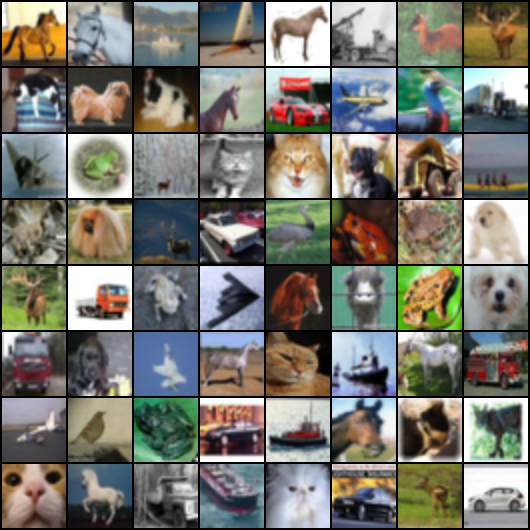

In [12]:
Image.open('output/GAN/real_samples.png')

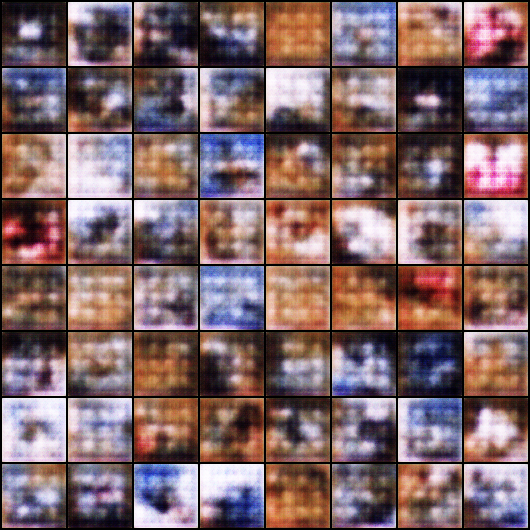

In [13]:
Image.open(f'output/GAN/fake_samples_epoch_{epochs-1:02d}.png')